### *IPCC SR15 scenario assessment*

<img style="float: right; height: 80px; padding-left: 20px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="../_static/IAMC_logo.jpg">

# Global emission pathway characteristics

## Figure 3a of the *Summary for Policymakers*

This notebook extracts the emissions pathways for Figure 3a in the Summary for Policymakers
of the IPCC's _"Special Report on Global Warming of 1.5°C"_.

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

### *Disclaimer*

*The figures shown in this notebook are NOT the same figures as used in Figure 3a of the SPM.
They are simplified figures included here only for reference.*

## Load `pyam` package and other dependencies

In [1]:
import pandas as pd
import numpy as np
import warnings
import io
import itertools
import yaml
import math
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('style_sr15.mplstyle')
%matplotlib inline
import pyam

<IPython.core.display.Javascript object>

## Import scenario data, categorization and specifications files

The metadata file must be generated from the notebook `sr15_2.0_categories_indicators` included in this repository.  
If the snapshot file has been updated, make sure that you rerun the categorization notebook.

The last cell of this section loads and assigns a number of auxiliary lists as defined in the categorization notebook.

In [2]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r1.1.xlsx')
#sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r1.1.xlsx')

INFO:root:Reading `../data/iamc15_scenario_data_world_r1.1.xlsx`
ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7f814f7ead40>)
Traceback (most recent call last):
  File "/Users/rebeccaciez1/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/rebeccaciez1/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 314, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [3]:
sr1p5.load_metadata('../data/sr15_metadata_indicators.xlsx')

INFO:root:Importing metadata for 416 scenarios (for total of 416)
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
with open("sr15_specs.yaml", 'r') as stream:
    specs = yaml.load(stream, Loader=yaml.FullLoader)

rc = pyam.run_control()
for item in specs.pop('run_control').items():
    rc.update({item[0]: item[1]})
cats = specs.pop('cats')
cats_15 = specs.pop('cats_15')
cats_15_no_lo = specs.pop('cats_15_no_lo')
marker= specs.pop('marker')

## Downselect scenario ensemble to categories of interest for this assessment

This figure only includes scenarios where the 2010 Kyoto GHG emissions are in line with the valid range as determined by the Second Assessment Report.

In [5]:
sr1p5.meta.rename(columns={'Kyoto-GHG|2010 (SAR)': 'kyoto_ghg_2010'}, inplace=True)

In [6]:
df = sr1p5.filter(category=cats_15, kyoto_ghg_2010='in range')

In [7]:
df.set_meta(meta='1.5C limited overshoot', name='supercategory', index=df.filter(category=cats_15_no_lo))
rc.update({'color': {'supercategory': {'1.5C limited overshoot': 'xkcd:bluish'}}})

## Set specifications for filters and initialize data list

In [8]:
filter_args = dict(df=df, category=cats, marker=None, join_meta=True)

In [9]:
data = []

## Plot different emissions pathways by category

### Net carbon dioxide emissions for all pathways limiting global warming to 1.5°C by the end of the century

In [10]:
co2 = (
    df.filter(variable='Emissions|CO2')
    .convert_unit({'Mt CO2/yr': ('Gt CO2/yr', 0.001)})
)
data.append(('Net carbon dioxide', co2))

[('Net carbon dioxide', <pyam.core.IamDataFrame at 0x7f81412e0c90>)]

/Users/rebeccaciez1/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2010.0, right=2010.0
  ax.set_xlim(left, right)
INFO:matplotlib.font_manager:findfont: Found a missing font file.  Rebuilding cache.
INFO:matplotlib.font_manager:Could not open font file /System/Library/Fonts/Supplemental/NISC18030.ttf


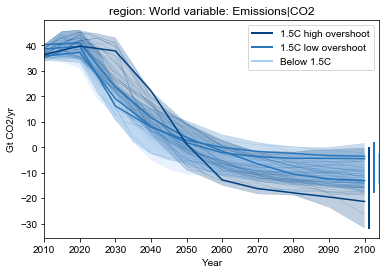

In [13]:
_co2 = co2.filter(category=cats_15, year=range(2010, 2101, 5))

fig, ax = plt.subplots()
_co2.filter(year=[2010]).line_plot(ax=ax, color='category', linewidth=2)
_co2.line_plot(ax=ax, color='category', linewidth=0.1, fill_between=True, final_ranges=True)
_co2.filter(marker=marker).line_plot(ax=ax, color='category')

In [14]:
type(_co2)

pyam.core.IamDataFrame

### Emissions of methane, black carbon and nitrous oxide for 1.5°C pathways with limited overshoot

The figures below are shown as reduction relative to 2010.

In [15]:
def plot_relative(data, baseyear=2010):
    _data = data.timeseries()
    _data_rel = pd.DataFrame()
    for y in range(2010, 2101, 5):
        _data_rel[y] = _data[y] / _data[2010]

    _data_rel.reset_index(inplace=True)
    _data_rel['unit'] = 'relative to {}'.format(baseyear)
    _df = pyam.IamDataFrame(_data_rel)
    _df.set_meta(meta='1.5C limited overshoot', name='supercategory')
    _df.filter(supercategory='1.5C limited overshoot', year=range(2010, 2101, 5))\
        .line_plot(color='supercategory', linewidth=0.1, fill_between=True, legend=False)

In [16]:
ch4 = df.filter(variable='Emissions|CH4')
data.append(('Methane', ch4))

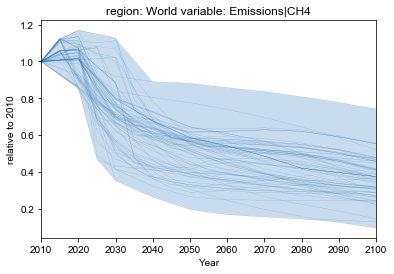

In [17]:
plot_relative(ch4)

In [18]:
bc = df.filter(variable='Emissions|BC')
data.append(('Black carbon', bc))

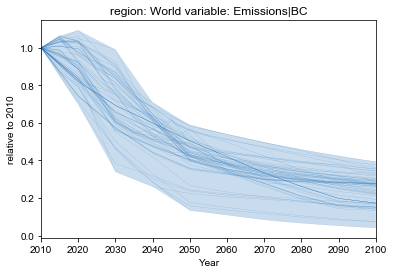

In [19]:
plot_relative(bc)

In [20]:
n2o = df.filter(variable='Emissions|N2O')
n2o.convert_unit({'kt N2O/yr': ('Mt N2O/yr', 0.001)}, inplace=True)
data.append(('Nitrous oxide', n2o))

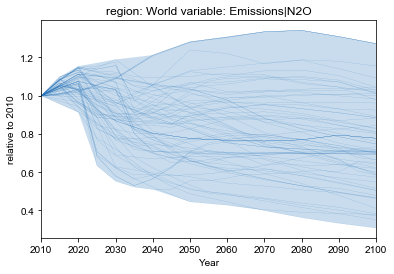

In [21]:
plot_relative(n2o)

## Save timeseries data to `xlsx`

In [41]:
writer = pd.ExcelWriter('output/spm_sr15_figure3a_data_table.xlsx')
for (name, _df) in data:
    pyam.utils.write_sheet(writer, name,
                           pyam.filter_by_meta(_df.timeseries(), **filter_args), index=True)
writer.save()

In [42]:
type(data)

list

In [43]:
len(data)

4

In [23]:
data

[('Net carbon dioxide', <pyam.core.IamDataFrame at 0x7f81412e0c90>),
 ('Methane', <pyam.core.IamDataFrame at 0x7f8148405790>),
 ('Black carbon', <pyam.core.IamDataFrame at 0x7f81474e31d0>),
 ('Nitrous oxide', <pyam.core.IamDataFrame at 0x7f812ed2c490>)]